# Parameter Identification Technique (PIT) on a linear VMM model

# Purpose
Show the general workflow by applying PIT regression on a very simple model

# Methodology
* Load time series from a ZigZag test
* Determine yaw rate and acceleration (compare with accelerometers from test).
* Find the best parameter values in the Nomoto model using OLS linear regression.

# Setup

In [ ]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src.models import linear_vmm
import src.linear_vmm_equations as eq


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Load test

In [ ]:
df_runs = mdl.runs()

In [ ]:
id=22773
df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')

In [12]:
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               20.0
angle2                                                               20.0
beam                                                             0.946602
comment                                                        ZZ 20/20PS
date                                                           2020-09-25
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [13]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,psi_filtered,r,r1d,r2d
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:13.700013,0.0,1.0,2.146755,0.798334,0.104886,15.505859,2.567061,57.348541,0.8,2.146755,1.009509,0.163203,15.505859,3.341054,58.867588,0.010956,-0.002530,-0.000086,0.000233,-0.005931,0.001067,9.569964,5.505012,-0.115821,9.590799,5.687483,0.111180,-0.000007,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001138,0.000295,0.000087,7.164215,-0.000099,0.002467,0.000081,0.000477,-0.000192,-0.000597
0 days 00:00:13.710002,0.0,1.0,2.146755,0.798334,-0.143440,15.505859,1.447828,57.348541,0.8,2.146755,1.009509,0.084455,15.505859,4.807634,58.867588,0.001283,-0.003820,-0.007830,0.003454,-0.005931,0.009445,9.628717,5.555121,-0.116216,9.541293,5.671445,0.108954,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001158,-0.000311,0.000087,7.164259,-0.000180,0.002405,0.000086,0.000545,-0.000222,-0.000661
0 days 00:00:13.720003,0.0,1.0,2.146755,0.798334,-0.360041,15.505859,1.621502,57.348541,0.8,2.146755,1.009509,-0.049593,15.505859,-0.421882,58.867588,0.010311,0.001982,-0.007830,0.013117,-0.006576,-0.001511,9.603547,5.633792,-0.114932,9.556246,5.599838,0.105735,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001134,0.000372,0.000087,7.183286,-0.000100,0.002487,0.000088,0.000625,-0.000254,-0.000724
0 days 00:00:13.730005,0.0,1.0,2.146755,0.798334,-0.380839,15.505859,1.698691,57.348541,0.8,2.146755,1.009509,-0.133511,15.505859,5.367251,58.867588,-0.008389,-0.004464,-0.009121,0.000877,-0.005286,0.001711,9.572272,5.710973,-0.112320,9.540091,5.487629,0.102544,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001152,-0.000409,0.000087,7.183280,-0.000181,0.002469,0.000092,0.000720,-0.000289,-0.000786
0 days 00:00:13.740018,0.0,1.0,2.146755,0.798334,-0.173223,15.505859,2.084633,57.348541,0.8,2.146755,1.009509,-0.117504,15.505859,1.797285,58.867588,0.007087,0.006495,-0.009121,0.009252,-0.001418,-0.004733,9.564290,5.755025,-0.109036,9.560101,5.364202,0.100559,-0.000014,0.645772,14.89,6.282836,1.0,-0.959931,0.000275,0.001127,0.000531,0.000087,7.193513,-0.000101,0.002443,0.000103,0.000813,-0.000322,-0.000846


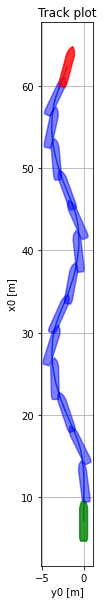

In [15]:
from mdldb.inspect import track_plot
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

## Yaw rate

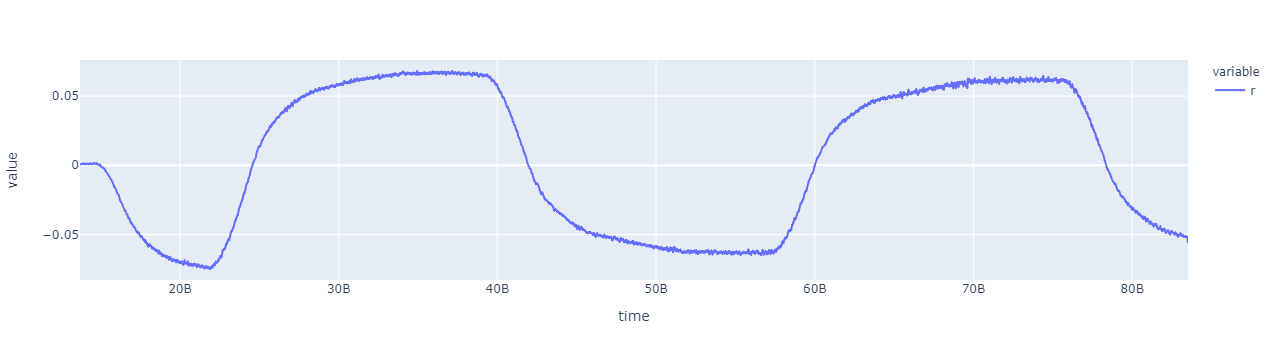

In [16]:
px.line(data_frame=df, y=['r'], width=1400, height=300,)

# Linear VMM

In [19]:
Math(vlatex(linear_vmm.r1d_eq))

<IPython.core.display.Math object>

# First order Nomoto model for ship maneuvering dynamics
The first order Nomoto model can be written as:

In [92]:
K, delta, T_1, T_2 = sp.symbols('K delta T_1 T_2')
r = dynamicsymbols('r')

eq_nomoto = sp.Eq(-K*delta,
                 r + T_1*r.diff() + T_2*r.diff().diff())
Math(vlatex(eq_nomoto))

<IPython.core.display.Math object>

where $r$ is yaw rate with its time derivatives and $\delta$ is the rudder angle. $K$, $T_{1}$
 and $T_{1}$ are the coefficients describing the hydrodynamics of the ship.
 
For slow manoeuvres this equation can be further simplified by removing the $\ddot{r}$ term:

In [93]:
eq_nomoto_simple = eq_nomoto.subs(r.diff().diff(),0)
Math(vlatex(eq_nomoto_simple))

<IPython.core.display.Math object>

In [94]:
eq_r1 = sp.Eq(r.diff(),
             sp.solve(eq_nomoto_simple, r.diff())[0])
r1d_lambda = lambdify(sp.solve(eq_nomoto_simple, r.diff())[0])
Math(vlatex(eq_r1))


<IPython.core.display.Math object>

In [95]:
def nomoto(t,states,df_control,params):
    """
    Simulation model for heading and yaw rate using Nomoto with only K and T_1
    """
    # states:
    psi = states[0]
    r = states[1]
    
    index = df_control.index.get_loc(t, method='nearest')
    delta = float(df_control['delta'].iloc[index])
    r1d_ = r1d_lambda(K=params['K'], T_1=params['T_1'], delta=delta, r=r)
    d_states_dt = np.array([r,r1d_])
    return d_states_dt

## Simulate a pull out manoeuvre
Simulating a simple pull out manoeuvre:

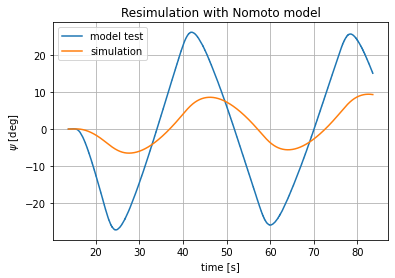

In [96]:
params = {
    'K' :  0.1,
    'T_1' : 10,
}

states_0 = np.array([df.iloc[0]['psi'],df.iloc[0]['r']])

df_control = df.copy()
df_control.index = df_control.index.total_seconds()
t = df_control.index

sol = solve_ivp(fun = nomoto,t_span=[t[0],t[-1]],t_eval=t, y0 = states_0, args=(df_control,params))
psi = sol.y[0,:]
r = sol.y[1,:]

fig,ax=plt.subplots()
df_control['psi_deg'] = np.rad2deg(df_control['psi'])
df_control.plot(y='psi_deg', label='model test', ax=ax)
ax.plot(t,np.rad2deg(psi), label='simulation');
ax.grid(True)
ax.set_title('Resimulation with Nomoto model')
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');
ax.legend()


## Regress nomoto parameters

In [97]:
eq_r1

Eq(Derivative(r(t), t), -(K*delta + r(t))/T_1)

In [98]:
import sympy.physics.mechanics as me

me.find_dynamicsymbols(eq_r1)

{Derivative(r(t), t), r(t)}

In [99]:
eq_r1.rhs

-(K*delta + r(t))/T_1

In [100]:
y = df_control['r1d']
X = df_control[['delta','r']] 

#y = df_control['r1d_numerical']
#X = df_control[['delta','r_numerical']] 
#X.rename(columns={'r_numerical': 'r'}, inplace=True)

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    r1d   R-squared (uncentered):                   0.912
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                          3.624e+04
Date:                Wed, 02 Jun 2021   Prob (F-statistic):                        0.00
Time:                        15:30:20   Log-Likelihood:                          29142.
No. Observations:                6983   AIC:                                 -5.828e+04
Df Residuals:                    6981   BIC:                                 -5.827e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
delta         -0.0910      0.000   -269.112      0.000      -0.092      -0.090
r             -0.5129      0.002   -242.998      0.000      -0.517      -0.509
==============================================================================
Omnibus:                      429.186   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.042
Skew:                          -0.657   Prob(JB):                    2.90e-111
Kurtosis:                       2.852   Cond. No.                         15.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

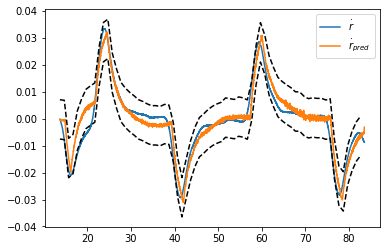

In [101]:
r1d_pred = results.predict(X)
X_ = X.iloc[::100, :]
prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)

fig,ax=plt.subplots()
ax.plot(t,y, label=r'$\dot{r}$')
ax.plot(t,r1d_pred, label=r'$\dot{r}_{pred}$')

ax.plot(X_.index,iv_l, 'k--')
ax.plot(X_.index,iv_u, 'k--')
ax.legend()

In [102]:
params['T_1'] = -1/results.params['r']
params['K'] = -results.params['delta']*params['T_1']

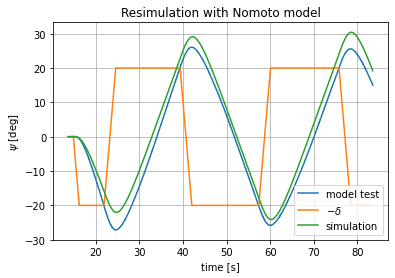

In [103]:
states_0 = np.array([df.iloc[0]['psi'],df.iloc[0]['r']])

df_control = df.copy()

df_control.index = df_control.index.total_seconds()
t = df_control.index

sol = solve_ivp(fun = nomoto,t_span=[t[0],t[-1]],t_eval=t, y0 = states_0, args=(df_control,params))
psi = sol.y[0,:]
r = sol.y[1,:]

fig,ax=plt.subplots()
df_control['psi_deg'] = np.rad2deg(df_control['psi'])
df_control.plot(y='psi_deg', label='model test', ax=ax)

df_control['-delta_deg'] = -np.rad2deg(df_control['delta'])
df_control.plot(y='-delta_deg', label=r'$-\delta$', ax=ax)

ax.plot(t,np.rad2deg(psi), label='simulation');
ax.grid(True)
ax.set_title('Resimulation with Nomoto model')
ax.set_ylabel('$\psi$ [deg]')
ax.set_xlabel('time [s]');
ax.legend();
